# Prediction on Titanic
The purpose of this notebook is to explore the data from the Titanic and be able to predict :

Who will survive, who will die ?

## Data preparation

Prior to loading the data, and to manipulate them, some preparation tasks have to be performed :
* importing the libraries
* defining functions for the graphs definitions

### Import the necessary libraries

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Regular expressions
import re as re

# Handle table-like data and matrices
import pandas as pd
import numpy as np

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.cross_validation import KFold
import xgboost as xgb

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
#sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8, 6

### Define graph functions

In [2]:
def plot_distribution(df, var, target, **kwargs ):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue = target, aspect = 4 ,row = row, col = col)
    facet.map(sns.kdeplot, var, shade = True)
    facet.set(xlim = (0, df[var].max()))
    facet.add_legend()

def plot_categories(df, cat, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, row = row, col = col)
    facet.map(sns.barplot, cat, target)
    facet.add_legend()

def plot_correlation_map(df):
    corr = titanic.corr()
    _, ax = plt.subplots(figsize = (22, 20))
    cmap = sns.diverging_palette(220, 10, as_cmap = True)
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={'shrink' : .9}, 
        ax = ax, 
        annot = True, 
        annot_kws = {'fontsize' : 12}
    )

### Loading the datasets
The dataset is composed of 2 csv files : the train and the test data files

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Lets store the PassengerId for an easier access

In [4]:
PassengerId = test['PassengerId']

Let's merge de train and test data frame to have a full vision of the Titanic passengers

In [5]:
full = train.append(test, ignore_index = True)
titanic = full[:89 ]

print ('Datasets:', 'full:', full.shape, 'titanic:', titanic.shape)

Datasets: full: (1309, 12) titanic: (89, 12)


## Data exploration
### Data Overview
Let's start looking at the first lines of the data

In [6]:
titanic.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


The dataset is composed of 1309 lines with a set of 12 variables.

The variables are described below:
* Survived: Survived (1) or died (0)
* Pclass: Passenger's class
* Name: Passenger's name
* Sex: Passenger's sex
* Age: Passenger's age
* SibSp: Number of siblings/spouses aboard
* Parch: Number of parents/children aboard
* Ticket: Ticket number
* Fare: Fare
* Cabin: Cabin
* Embarked: Port of embarkation

Let's have a look at the data descriptions.

In [7]:
titanic.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,68.0,26.122500,14.681575,0.830,NaN,NaN,NaN,66.0
Fare,89.0,30.154447,42.840442,7.225,8.05,15.5,31.3875,263.0
Parch,89.0,0.449438,1.000128,0.000,0.00,0.0,0.0000,5.0
PassengerId,89.0,45.000000,25.836021,1.000,23.00,45.0,67.0000,89.0
Pclass,89.0,2.415730,0.809166,1.000,2.00,3.0,3.0000,3.0
SibSp,89.0,0.786517,1.229116,0.000,0.00,0.0,1.0000,5.0
Survived,89.0,0.438202,0.498978,0.000,0.00,0.0,1.0000,1.0


## Data preparation and cleaning
As there are NaN values and strings, lets do some transformation to use all the possible features of the dataset.
we can also add some features such as the family size or if the people is alone.
### Adding features

In [8]:
# Feature that tells whether a passenger had a cabin or not 
full['Has_Cabin'] = full["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
full['FamilySize'] = full["SibSp"] + full["Parch"] + 1

# Create new feature IsAlone from FamilySize
full['IsAlone'] = full["FamilySize"].apply(lambda x: 1 if x == 1 else 0)

# Lets add a column for the sex in binary format with 0 for male and 1 for female
full['SexBin'] = full['Sex'].apply(lambda x: 0 if x == 'male' else 1)

In the Name column some interresting the title can be extracted to create a new feature.

In [9]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

full['Title'] = full['Name'].apply(lambda x: get_title(x))


print(pd.crosstab(full['Title'], full['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     4
Countess       1     0
Don            0     1
Dona           1     0
Dr             1     7
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    61
Miss         260     0
Mlle           2     0
Mme            1     0
Mr             0   757
Mrs          197     0
Ms             2     0
Rev            0     8
Sir            0     1


Lets categorize the title in order to have a clearer feature. This will help also to separate the passengers from the crew members.

In [10]:
full['Title'] = full['Title'].replace('Mlle', 'Miss')
full['Title'] = full['Title'].replace('Ms', 'Miss')
full['Title'] = full['Title'].replace('Mme', 'Mrs')
full['Title'] = full['Title'].replace(['Lady', 'Countess'], 'Mrs')
full['Title'] = full['Title'].replace(['Capt', 'Col', 'Dr', 'Major'], 'Crew')
full['Title'] = full['Title'].replace(['Don', 'Rev', 'Sir', 'Jonkheer'], 'Mr')

full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Has_Cabin,FamilySize,IsAlone,SexBin,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,0,2,0,0,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,1,2,0,1,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,0,1,1,1,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,1,2,0,1,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,0,1,1,0,Mr


Lets extract Cabin category information from the Cabin number.

In [11]:
cabin = pd.DataFrame()

# replacing missing cabins with U (for Uknown)
cabin['Cabin'] = full['Cabin'].fillna('U')
full['Cabin'].fillna('U')

# mapping each Cabin value with the cabin letter
cabin['Cabin'] = cabin['Cabin'].map(lambda c: c[0])

# dummy encoding ...
cabin = pd.get_dummies(cabin['Cabin'], prefix = 'Cabin')

cabin.head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Then merge de cabin data frame with the full one.

In [12]:
full = full.merge(cabin, left_index=True, right_index=True)

Lets extract ticket class from ticket number

In [13]:
# Extraction of each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket(ticket):
    ticket = ticket.replace('.', '' )
    ticket = ticket.replace('/', '' )
    ticket = ticket.split()
    ticket = map(lambda t: t.strip(), ticket)
    ticket = list(filter(lambda t: not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'

ticket = pd.DataFrame()

# Extracting dummy variables from tickets:
ticket['Ticket'] = full['Ticket'].map(cleanTicket)
ticket = pd.get_dummies(ticket['Ticket'], prefix = 'Ticket')

ticket.shape
ticket.head()

,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Then merge de ticket data with the full data frame.

In [14]:
full = full.merge(ticket, left_index=True, right_index=True)

### Removing NaN values

In [15]:
#Lets identify the columns with NULL values
full.info()

# Remove all NULLS in the Embarked column assuming that all passengers with NaN values boarded at Southampton.
full['Embarked'].fillna('S')

# Fare also has some missing value and we will replace it with the median.
full['Fare'] = full['Fare'].fillna(full['Fare'].median())

# Age also have NULL values. Let's fill the NaN values with random numbers between (mean - std) and (mean + std)
age_avg = full['Age'].mean()
age_std = full['Age'].std()

full['Age'] = full['Age'].fillna(np.random.randint(age_avg - age_std, age_avg + age_std, size=1)[0])

# Create a new column for the cabin in a binary format with 1 if the passenger has a cabin assigned to him
full['HasCabin'] = full['Cabin'].apply(lambda x: 1 if pd.notnull(x) else 0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 63 columns):
Age               1046 non-null float64
Cabin             295 non-null object
Embarked          1307 non-null object
Fare              1308 non-null float64
Name              1309 non-null object
Parch             1309 non-null int64
PassengerId       1309 non-null int64
Pclass            1309 non-null int64
Sex               1309 non-null object
SibSp             1309 non-null int64
Survived          891 non-null float64
Ticket            1309 non-null object
Has_Cabin         1309 non-null int64
FamilySize        1309 non-null int64
IsAlone           1309 non-null int64
SexBin            1309 non-null int64
Title             1309 non-null object
Cabin_A           1309 non-null float64
Cabin_B           1309 non-null float64
Cabin_C           1309 non-null float64
Cabin_D           1309 non-null float64
Cabin_E           1309 non-null float64
Cabin_F           1309 non-null float

## Feature data correlation
To see which variables are important, let's graph a heat map of correlation without the ticket and cabin information.

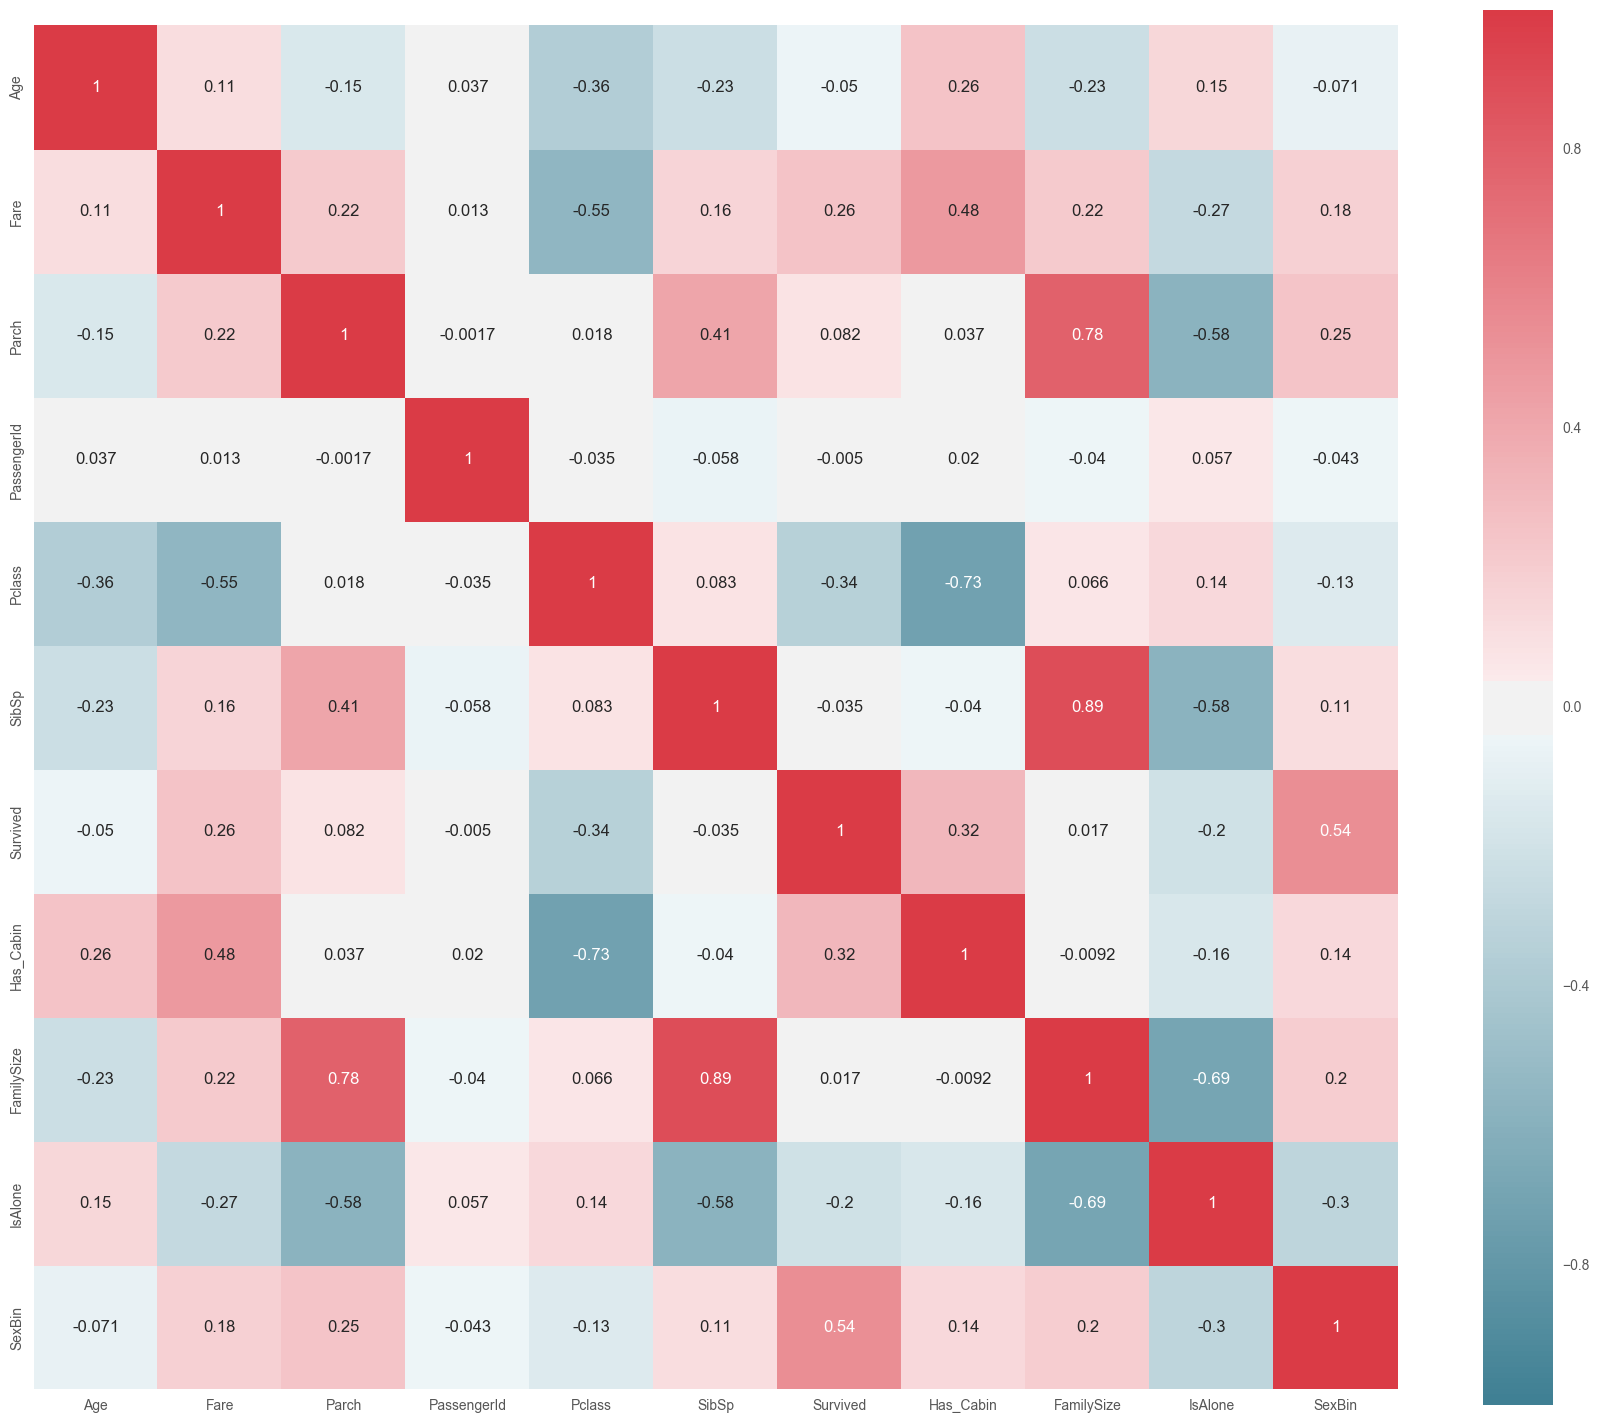

In [16]:
titanic = full[:891]
titanic_map = titanic.drop(titanic.columns[17:], axis=1, inplace=True)
plot_correlation_map(titanic_map)

The Correlation plot shows that there are not too many features strongly correlated with one another. 
This point will in interresting for the feeding of the learnong modelthis means that there isn't much redundant or superfluous data in our training set and that each feature carries with it some unique information. The most correlated features is Parch (Parents and Children).

## Data visualization
Let's explore the relationship between the different features and the survival of passenger.
### Survival rate by age
The graph below shows the relationship between the age and the survived variables.

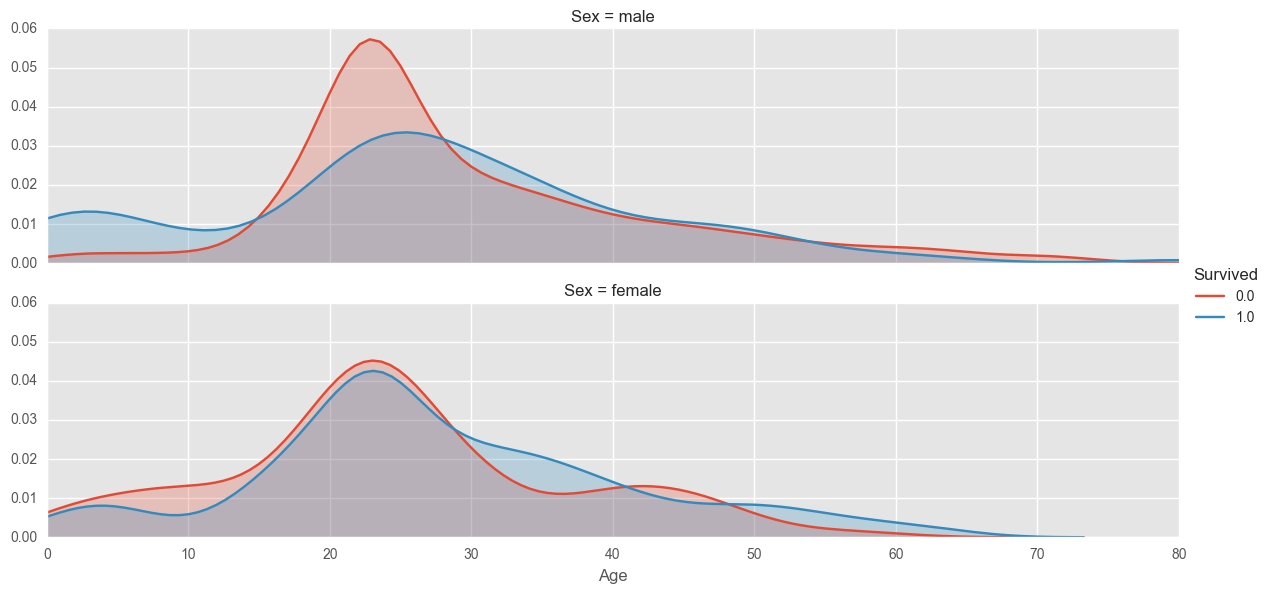

In [17]:
plot_distribution(titanic, var = 'Age', target = 'Survived', row = 'Sex')

This distribution marks clearly a high probability for each sex people to have the capability to survive. Young male (below 15) have a higher chance to survive rather than older one (15 to 32 years old).
For female, the probability to survive is when you are between 25 and 41, then older than 50 years old.

Lets split by 5 the age by sex to have an overview of the probability to survive.

In [18]:
titanic['CategoricalAge'] = pd.cut(titanic['Age'], 5)

print (titanic[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

     CategoricalAge  Survived
0    (0.34, 16.336]  0.550000
1  (16.336, 32.252]  0.344168
2  (32.252, 48.168]  0.404255
3  (48.168, 64.084]  0.434783
4      (64.084, 80]  0.090909


Whatever is the sex, young people (below 16 years old) have a higher chance to survive whereas the older than 64 years have a really high probability not to survive.
### Survival rate by Fare
The graph below shows the relationship between the fare of passangers and the survived variables.

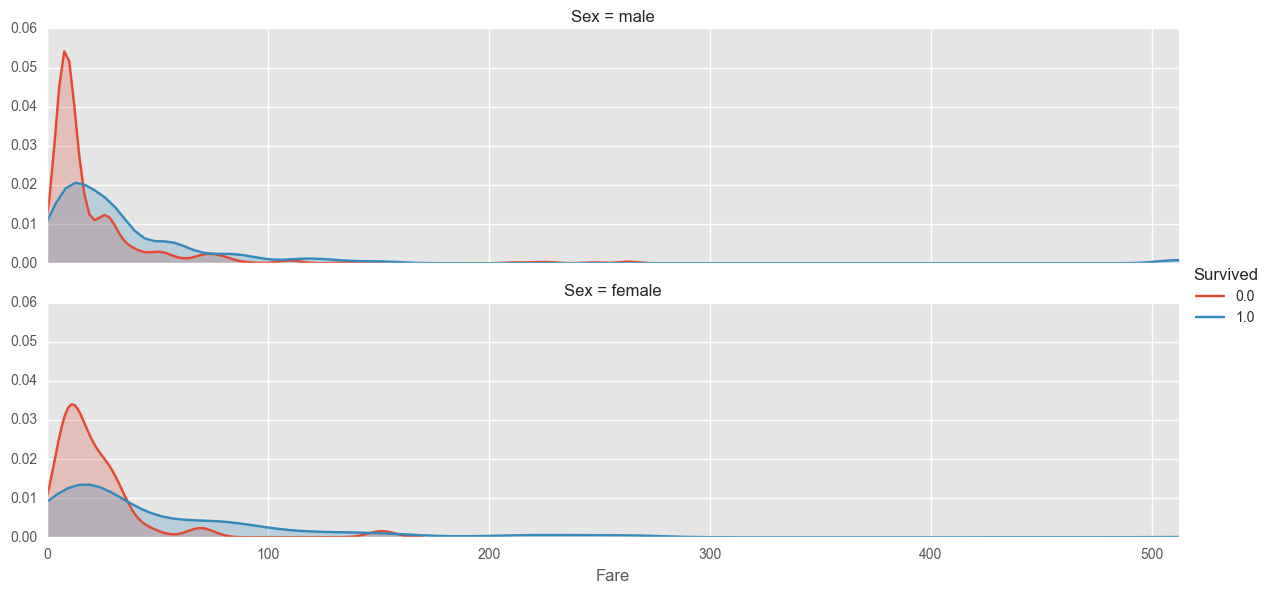

In [19]:
plot_distribution(titanic, var = 'Fare', target = 'Survived', row = 'Sex')

Lets categorize the fare into 4 ranges.

In [20]:
titanic['CategoricalFare'] = pd.qcut(titanic['Fare'], 5)
print (titanic[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

     CategoricalFare  Survived
0         [0, 7.854]  0.217877
1      (7.854, 10.5]  0.201087
2     (10.5, 21.679]  0.424419
3   (21.679, 39.688]  0.444444
4  (39.688, 512.329]  0.642045


This distribution graph shows that whatever is your sex (male or female), your probability to died is higher when your fare is low.

### Survival rate by Embarkment place
The graph below shows the relationship between the embarkment place and the survival probability.
The embarkment places are the following ones :
* C = Cherbourg
* Q = Queenstown
* S = Southampton

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957


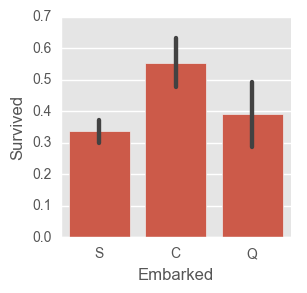

In [21]:
plot_categories(titanic, cat = 'Embarked' ,target = 'Survived')
print (titanic[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

Passengers who have embarked at Cherbourg have a higher chance to survive rather than the others. Southampton passengers are the one who have the most chance not to survive.
### Survival rate by Sex
The graph below shows the survival rate by Sex.

      Sex  Survived
0  female  0.742038
1    male  0.188908


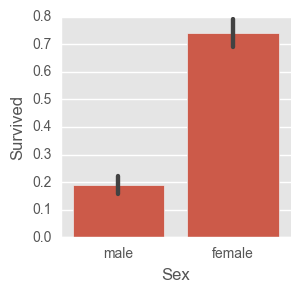

In [22]:
print(titanic[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())
plot_categories(titanic, cat = 'Sex', target = 'Survived')

Being a male or a female has an impact on the survival rate.
### Survival rate by family size
The graph below shows the survival rate by family size.

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


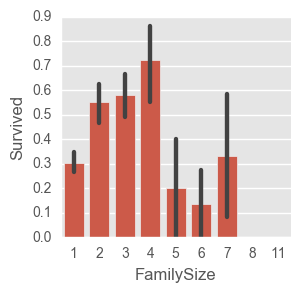

In [23]:
print(titanic[["FamilySize", "Survived"]].groupby(['FamilySize'], as_index=False).mean())
plot_categories(titanic, cat = 'FamilySize', target = 'Survived')

Let's have a look at the single family with the below graph.

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


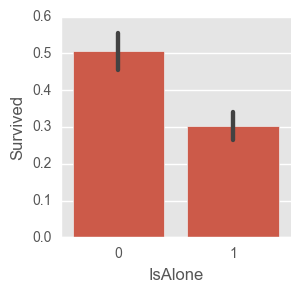

In [24]:
print(titanic[["IsAlone", "Survived"]].groupby(['IsAlone'], as_index=False).mean())
plot_categories(titanic, cat = 'IsAlone', target = 'Survived')

Having a family not more than 4 people provide a larger chance to survive than the other. The largest family has no chance according to the data set.
### Survival rate by Passenger class
The graph below shows the survival rate by passenger class.

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


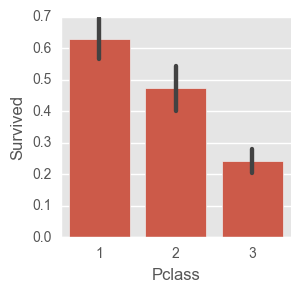

In [25]:
print(titanic[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean())
plot_categories(titanic, cat = 'Pclass', target = 'Survived')

The higher is the class the more chance to survive is.
### Survival rate by cabin
The graph below shows the survival rate whereas the passenger has a cabin assigned to him or not.

   HasCabin  Survived
0         0  0.299854
1         1  0.666667


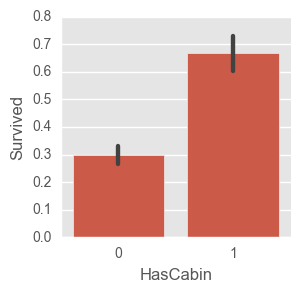

In [26]:
# Use all the columns
titanic = full[:891]
print(titanic[["HasCabin", "Survived"]].groupby(['HasCabin'], as_index=False).mean())
plot_categories(titanic, cat = 'HasCabin', target = 'Survived')

Having a cabin drives to a higher chance to survie than not having one. Lets' do a correlation map only focussed on the cabin type.

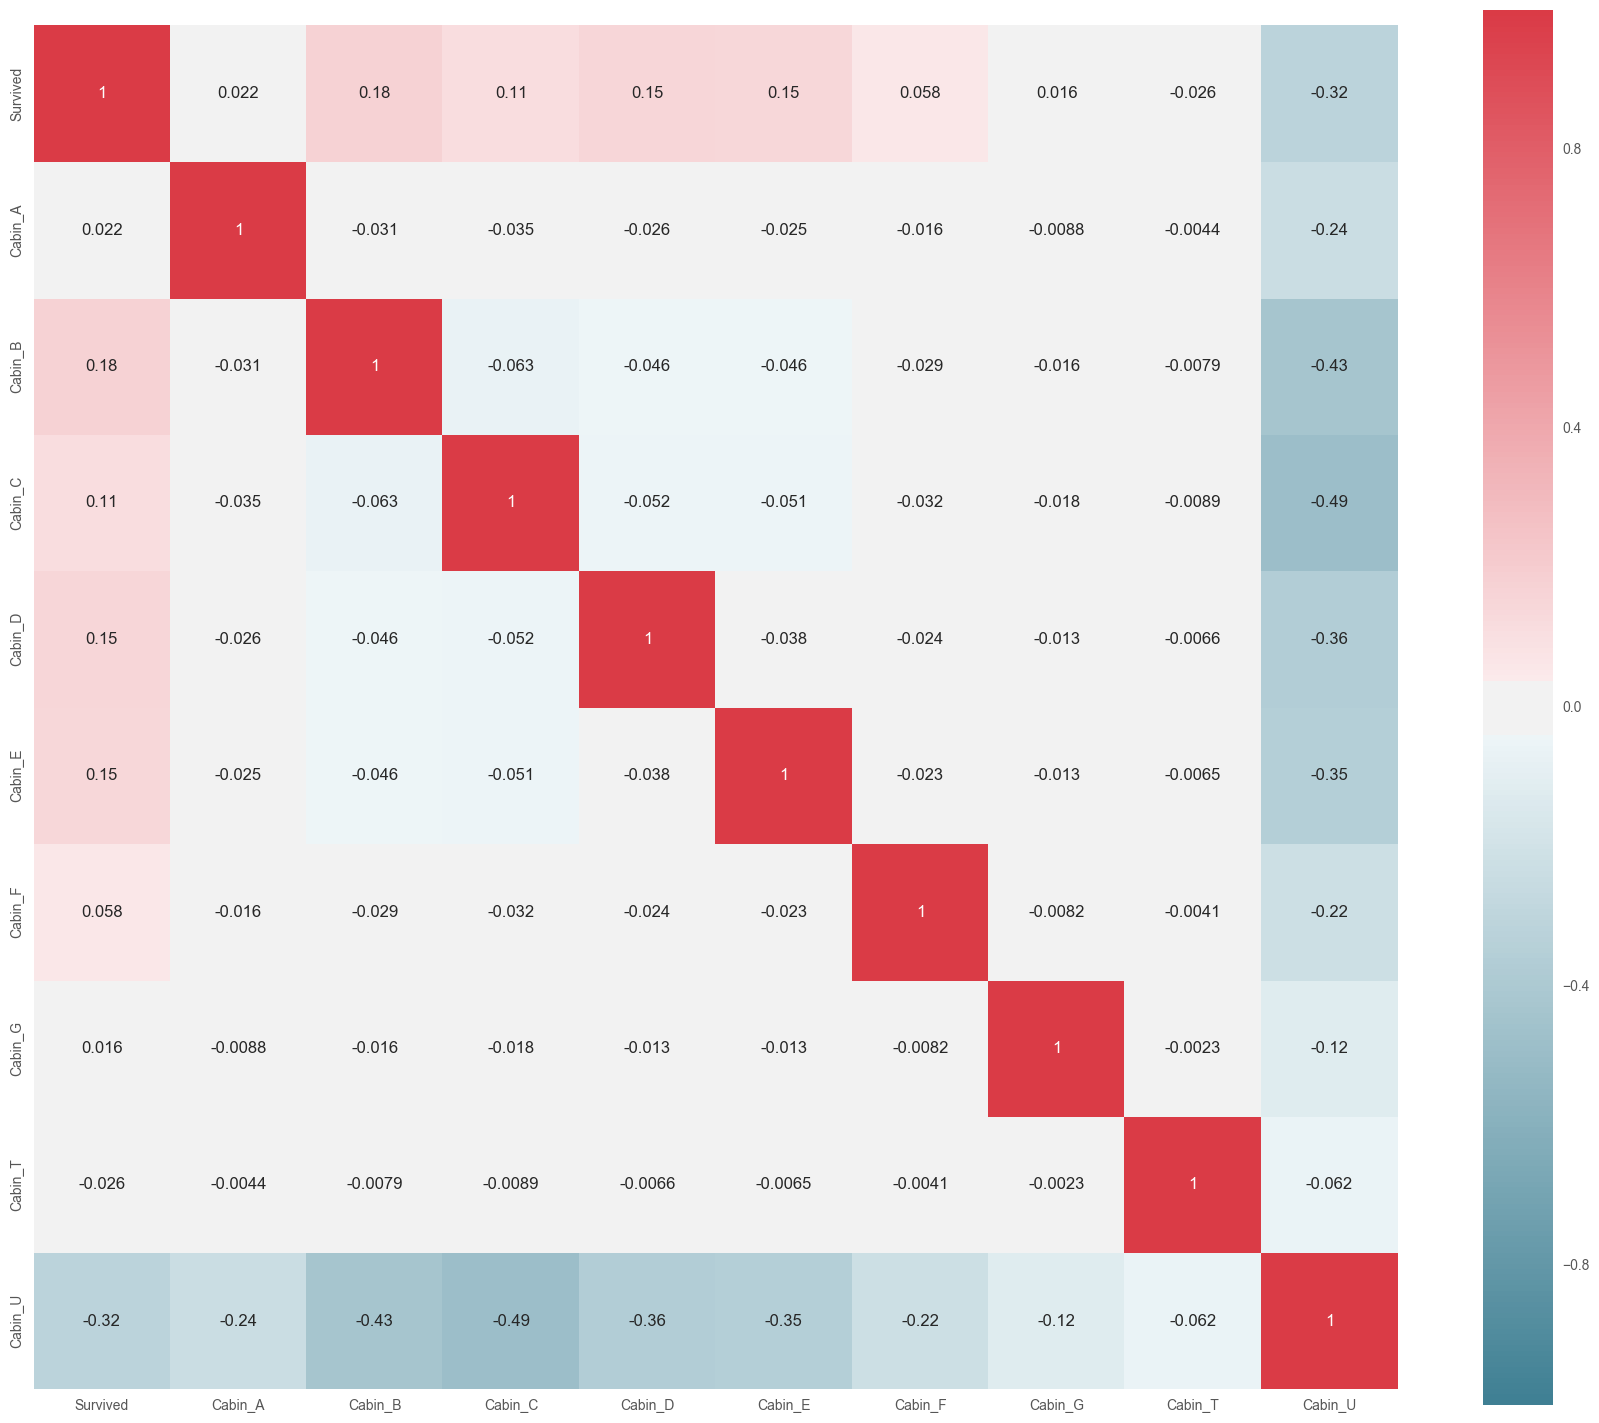

In [27]:
titanic = full[:891]
titanic_map = titanic.drop(titanic.columns[26:], axis=1, inplace=True)
titanic_map = titanic.drop(titanic.columns[:10], axis=1, inplace=True)
titanic_map = titanic.drop(titanic.columns[1:6], axis=1, inplace=True)

plot_correlation_map(titanic_map)

Some correlation can be made also with the cabin type. However, with the number of unknown cabin type (Cabin_U), this feature is not one of the most relevant.
### Survival rate by title
The graph below shows the survival rate by title.

    Title  Survived
0    Crew  0.416667
1  Master  0.575000
2    Miss  0.702703
3      Mr  0.155894
4     Mrs  0.796875


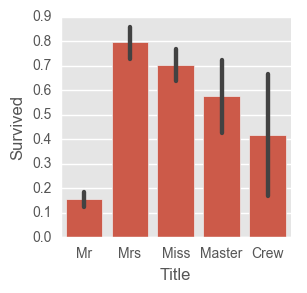

In [28]:
print(titanic[["Title", "Survived"]].groupby(['Title'], as_index=False).mean())
plot_categories(titanic, cat = 'Title', target = 'Survived')

The title is an interresting feature as it is also summaryzing some information compared to the previous one such as sex, age.
Being a man give less chance to survice than a female. It is also observed that young men have a higher chance to survive than aldults one.
This feature provide also a vision of the survival rate of the crew members.
# Modeling
We will now select a model we would like to try then use the training dataset to train this model and thereby check the performance of the model using the test set.
## Final cleaning
Prior to the modeling selection, lets do some final cleaning and feature arrangment to be able to manage them all. The features which needs to be adjusted is:
* Embarked

In [29]:
# Create a new variable for every unique value of Embarked
embarked = pd.get_dummies(full['Embarked'], prefix='Embarked')
embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


Then merge the generated embarked data with the full data frame.

In [30]:
full = full.merge(embarked, left_index=True, right_index=True)
full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,HasCabin,Embarked_C,Embarked_Q,Embarked_S
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,0.0,0.0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,...,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,0.0,1.0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,1.0


Now we will remove the strings columns and all the tickets columns:
* Cabin
* Embarked
* Name
* Sex
* Ticket
* Title
* PassengerId

In [31]:
full.drop(full.columns[[1, 2, 4, 6, 8, 11, 16]], axis=1, inplace = True)
full.drop(full.columns[19:], axis = 1, inplace = True)
full.head()

,Age,Fare,Parch,Pclass,SibSp,Survived,Has_Cabin,FamilySize,IsAlone,SexBin,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,22.0,7.2500,0,3,1,0.0,0,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,38.0,71.2833,0,1,1,1.0,1,2,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26.0,7.9250,0,3,0,1.0,0,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,35.0,53.1000,0,1,1,1.0,1,2,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35.0,8.0500,0,3,0,0.0,0,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Create datasets
Lets create training and test datasets.

In [32]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 19 columns):
Age           1309 non-null float64
Fare          1309 non-null float64
Parch         1309 non-null int64
Pclass        1309 non-null int64
SibSp         1309 non-null int64
Survived      891 non-null float64
Has_Cabin     1309 non-null int64
FamilySize    1309 non-null int64
IsAlone       1309 non-null int64
SexBin        1309 non-null int64
Cabin_A       1309 non-null float64
Cabin_B       1309 non-null float64
Cabin_C       1309 non-null float64
Cabin_D       1309 non-null float64
Cabin_E       1309 non-null float64
Cabin_F       1309 non-null float64
Cabin_G       1309 non-null float64
Cabin_T       1309 non-null float64
Cabin_U       1309 non-null float64
dtypes: float64(12), int64(7)
memory usage: 194.4 KB


## Selecting the right model
First lets initialize some parameters which are going to be used later on.

In [33]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

We will use the predictions of base classifiers as input for training to a second-level model. However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

In [34]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

### Generating the first level of model
The following models will be tested :
* Random Forest classifier
* Extra Trees classifier
* AdaBoost classifer
* Gradient Boosting classifer
* Support Vector Machine
* Decision Tree Classifier
* Logistic Regression

Parameters

Just a quick summary of the parameters that we will be listing here for completeness:
* n_jobs : Number of cores used for the training process. If set to -1, all cores are used.
* n_estimators : Number of classification trees in your learning model ( set to 10 per default)
* max_depth : Maximum depth of tree, or how much a node should be expanded. Beware if set to too high a number would run the risk of overfitting as one would be growing the tree too deep
* verbose : Controls whether you want to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.

Lets initalialize the parameters for the different models

In [35]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

# Decision Tree parameters
dt_params = {
    'criterion': 'gini',
    'max_features' : 'sqrt'
}

# Logistic Regression parameters
lr_params = {
    'warm_start': True,
    'verbose': 0,
    'n_jobs': 4
}

Create the objects which represents the models using the class defined above.

In [36]:
rf = SklearnHelper(clf = RandomForestClassifier, seed = SEED, params = rf_params)
et = SklearnHelper(clf = ExtraTreesClassifier, seed = SEED, params = et_params)
ada = SklearnHelper(clf = AdaBoostClassifier, seed = SEED, params = ada_params)
gb = SklearnHelper(clf = GradientBoostingClassifier, seed = SEED, params = gb_params)
svc = SklearnHelper(clf = SVC, seed = SEED, params = svc_params)
dt = SklearnHelper(clf = DecisionTreeClassifier, seed = SEED, params = dt_params)
lr = SklearnHelper(clf = LogisticRegression, seed = SEED, params = lr_params)

#### Creation of the test and train data sets

In [37]:
# Create all datasets that are necessary to train, validate and test models
train = full[0:891]
train_valid = train['Survived']
test = full[891:]
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis = 1)
test = test.drop(['Survived'], axis = 1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creates an array of the test data

#### Check data validation before launching the predictions
As the input shouldn't contains NaN, inifity or a too large value, let's check that the data set are conform to this by using the function _assert_all_finite().
No error message should be raise.

In [38]:
def _assert_all_finite(X):
    """Like assert_all_finite, but only for ndarray."""
    X = np.asanyarray(X)
    # First try an O(n) time, O(1) space solution for the common case that
    # everything is finite; fall back to O(n) space np.isfinite to prevent
    # false positives from overflow in sum method.
    if (X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum())
            and not np.isfinite(X).all()):
        raise ValueError("Input contains NaN, infinity"
                         " or a value too large for %r." % X.dtype)
        
_assert_all_finite(y_train)
_assert_all_finite(x_train)
_assert_all_finite(x_test)

#### Output of the First level Predictions
We will use the Out-of-Fold prediction function we defined earlier to generate our first level predictions. This will take some time to acheive this step.

In [39]:
# Create our OOF train and test predictions. These base results will be used as new features
print("Training Extra Trees")
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees

print("Training Random Forest")
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test) # Random Forest

print("Training AdaBoost")
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 

print("Training Gradient Boost")
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test) # Gradient Boost

print("Training Support Vector Classifier")
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test) # Support Vector Classifier

print ("Training Decision Tree Classifier")
dt_oof_train, dt_oof_test = get_oof(dt, x_train, y_train, x_test) # Decision Tree Classifier

print("Training Logistic Regression")
lr_oof_train, lr_oof_test = get_oof(lr, x_train, y_train, x_test) # Logistic Regression

print("Training is complete")

Training Extra Trees
Training Random Forest
Training AdaBoost
Training Gradient Boost
Training Support Vector Classifier
Training Decision Tree Classifier
Training Logistic Regression
Training is complete


#### Feature importances generated from the different classifiers

Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models and that is to output the importances of the various features in the training and test sets with one very simple line of code.
As per the Sklearn documentation, most of the classifiers are built in with an attribute which returns feature importances by simply typing in .featureimportances. Therefore we will invoke this very useful attribute via our function earliand plot the feature importances as such.

The following modelling algorithm don't have any feature importance method
* Support Vector Classifier
* Logistic Regression

In [40]:
print("Extra Tree feature")
et_feature = et.feature_importances(x_train, y_train)
print("Random Forest feature")
rf_feature = rf.feature_importances(x_train, y_train)
print("AdaBoost feature")
ada_feature = ada.feature_importances(x_train, y_train)
print("Gradient Boost feature")
gb_feature = gb.feature_importances(x_train, y_train)
print("Decision Tree feature")
dt_feature = dt.feature_importances(x_train, y_train)

Extra Tree feature
[ 0.04986165  0.04305943  0.01914804  0.11100785  0.0262006   0.06761207
  0.03463144  0.03148966  0.50132581  0.00343629  0.01064977  0.00837839
  0.00636622  0.0119842   0.00388592  0.0024894   0.          0.06847326]
Random Forest feature
[ 0.11103223  0.17568583  0.02461581  0.11310776  0.02657616  0.05066801
  0.0581543   0.01922836  0.33649598  0.00308093  0.00951557  0.00711323
  0.00388955  0.01000068  0.00177158  0.00085905  0.          0.04820497]
AdaBoost feature
[ 0.264  0.596  0.03   0.002  0.006  0.004  0.058  0.     0.018  0.     0.002
  0.002  0.004  0.006  0.     0.004  0.002  0.002]
Gradient Boost feature
[ 0.34819418  0.46165555  0.00882054  0.02913418  0.01627056  0.00753766
  0.02777844  0.00539918  0.05224203  0.00578719  0.00365409  0.01134988
  0.00459731  0.00646322  0.00189304  0.00057526  0.          0.00864771]
Decision Tree feature
[ 0.24851115  0.25326076  0.01801997  0.03129199  0.02532923  0.03752831
  0.04545353  0.0017088   0.3079147

Lets store the features importance in an array

In [41]:
et_features = [ 0.05011595,  0.04284341,  0.01921525,  0.110844,    0.02640853,  0.06698562,
  0.03532985,  0.03189318,  0.50049825,  0.00339117,  0.01068302,  0.00837521,
  0.00637922,  0.01190591,  0.00395718,  0.0025294,   0.,          0.06864485]
rf_features = [ 0.11046156,  0.17613965,  0.02475541,  0.11329302,  0.02709934,  0.04966605,
  0.05802088,  0.01890127,  0.33654778,  0.00299868,  0.00953418,  0.00731309,
  0.00395437,  0.01009517,  0.00173278,  0.00089213,  0.,          0.04859466]
ada_features = [ 0.256,  0.604,  0.032,  0.002,  0.006,  0.002,  0.056,  0.,     0.018,  0.,     0.002,
  0.002,  0.004,  0.006,  0.,     0.004,  0.002,  0.004]
gb_features = [  3.65903579e-01,   4.64744988e-01,   8.72998258e-03,   2.40536109e-02,
   1.66487753e-02,   6.83559768e-03,   2.52165063e-02,   4.89974450e-03,
   4.91318415e-02,   4.08279904e-03,   4.04680366e-03,   1.09309351e-02,
   2.62153988e-03,   4.50583486e-03,   1.36484913e-03,   2.57626670e-04,
   0.00000000e+00,   6.02498557e-03]
dt_features = [ 0.28184935,  0.22410379,  0.02291037,  0.0276042,   0.03999138,  0.0498649,
  0.01866463,  0.00782725,  0.30692013,  0.00136774,  0.00356788,  0.0054007,
  0.00134339,  0.00729523,  0.,          0.00128904,  0.,          0.        ]

Create a dataframe from the lists containing the feature importance data for easy plotting via the Plotly package.

In [42]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
    'Random Forest feature importances': rf_features,
    'Extra Trees feature importances': et_features,
    'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features,
    'Decision Tree feature importances': dt_features
    })

#### Interactive feature importances via Plotly scatterplots
Lets graph Random Forest feature importances

In [43]:
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='fig1_rf')

Lets graph Extra trees features importance

In [44]:
trace = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='fig1_et')


Lets graph Ada boost feature importance

In [45]:
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='fig1_gf')

Lets graph Gradient boost feature importances

In [46]:
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='fig1_gb')

Lets graph Decision Tree feature importance

In [47]:
trace = go.Scatter(
    y = feature_dataframe['Decision Tree feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Decision Tree feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Decision Tree Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='fig1_gb')

Lets calculate the mean of all the feature importances and store it as a new column in the feature importance dataframe.

In [48]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head()

,AdaBoost feature importances,Decision Tree feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.256,0.281849,0.050116,0.365904,0.110462,Age,0.212866
1,0.604,0.224104,0.042843,0.464745,0.176140,Fare,0.302366
2,0.032,0.022910,0.019215,0.008730,0.024755,Parch,0.021522
3,0.002,0.027604,0.110844,0.024054,0.113293,Pclass,0.055559
4,0.006,0.039991,0.026409,0.016649,0.027099,SibSp,0.023230


#### Plot the main important features
The graph below shows the mean feature importance accross all the tested models.

In [49]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

### Second-Level Predictions from the First-level Output
#### First-level output as new features
Having now obtained our first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier. As per the code below, we are therefore having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.

In [50]:
base_predictions_train = pd.DataFrame( {
    'RandomForest': rf_oof_train.ravel(),
    'ExtraTrees': et_oof_train.ravel(),
    'AdaBoost': ada_oof_train.ravel(),
    'GradientBoost': gb_oof_train.ravel(),
    'DecisionTree': dt_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,DecisionTree,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0


#### Correlation Heatmap of the Second Level Training set

In [51]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Portland',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='corr-heatmap')

Lets now concatenate and join both the first-level train and test predictions as x_train and x_test, we can now fit a second-level learning model.

In [52]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

### Second level learning model via XGBoost
XGBClassifier and fit it to the first-level train and target data and use the learned model to predict the test data as follows:

In [53]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
    n_estimators= 2000,
    max_depth= 4,
    min_child_weight= 2,
    #gamma=1,
    gamma=0.9,                        
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread= -1,
    scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

#### Producing the Submission file
Finally having trained and fit all our first-level and second-level models, we can now output the predictions into the proper format for submission to the Titanic competition as follows:

In [59]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({'PassengerId': PassengerId, 'Survived': predictions})

# Correcting the output format
StackingSubmission['Survived'].astype(int)

# Generating the CSV file
StackingSubmission.to_csv("StackingSubmission3.csv", index=False)

# Steps for Further Improvement
As a closing remark it must be noted that the steps taken above just show a very simple way of producing an ensemble stacker. You hear of ensembles created at the highest level of Kaggle competitions which involves monstrous combinations of stacked classifiers as well as levels of stacking which go to more than 2 levels.

Some additional steps that may be taken to improve one's score could be:
* Implementing a good cross-validation strategy in training the models to find optimal parameter values
* Introduce a greater variety of base models for learning. The more uncorrelated the results, the better the final score. (commented ones)